In [1]:
%matplotlib inline
import os
os.chdir('/media/DATA/Pro/Projects/Paris/Orientation/Niccolo/Paris_orientation-decoding')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from mne.time_frequency import single_trial_power
from mne.decoding import GeneralizationAcrossTime
from base import load_epochs_events, resample_epochs, decim
from config import paths, subjects, preproc, analyses
from jr.gat import scorer_auc
# Select target presence analysis: strongest SNR
analysis = [ii for ii in analyses if ii['name'] == 'target_present'][0]

In [3]:
def load_data(subject):
    # load data
    epochs, events = load_epochs_events(subject, paths)
    
    # remove meaningless trials
    query, condition = analysis['query'], analysis['condition']
    sel = range(len(events)) if query is None else events.query(query).index
    sel = [ii for ii in sel if ~np.isnan(events[condition][sel][ii])]
    
    # set regressor
    y = np.array(events[condition], dtype=np.float32)
    
    return epochs, y

In [6]:
from jr.gat import TimeFrequencyDecoding, scorer_auc
from mne.decoding import TimeDecoding

epochs, y = load_data(subjects[0])
epochs.pick_types(meg='mag')

<EpochsArray  |  n_events : 841 (all good), tmin : -0.203125 (s), tmax : 1.203125 (s), baseline : None,
 '1': 20, '10': 20, '11': 20, '12': 20, '13': 20, '14': 20, '15': 20, '16': 20, '17': 20, '18': 20, '19': 80, '2': 20, '20': 81, '21': 80, '22': 80, '23': 80, '24': 80, '3': 20, '4': 20, '5': 20, '6': 20, '7': 20, '8': 20, '9': 20>

In [19]:
tfd = TimeFrequencyDecoding(freqs=np.arange(5., 10., 4), tfr_kwargs=dict(decim=10, n_cycles=3), n_jobs=-1)
tfd.fit(epochs)

Computing time-frequency power on single epochs...


[Parallel(n_jobs=8)]: Done   1 out of 355 | elapsed:    0.0s remaining:    7.1s
[Parallel(n_jobs=8)]: Done 167 out of 841 | elapsed:    0.5s remaining:    2.2s
[Parallel(n_jobs=8)]: Done 336 out of 841 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=8)]: Done 505 out of 841 | elapsed:    1.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done 674 out of 841 | elapsed:    2.1s remaining:    0.5s
[Parallel(n_jobs=8)]: Done 841 out of 841 | elapsed:    2.7s finished


No baseline correction applied
841 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:   59.6s remaining:   19.9s
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:   59.9s remaining:  7.0min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.0min remaining:  3.0min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.0min finished


<__main__.TimeFrequencyDecoding instance at 0x7f4dfccde320>

In [20]:
tfd.td.n_jobs = -1
scores = tfd.score()

[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=8)]: Done   1 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


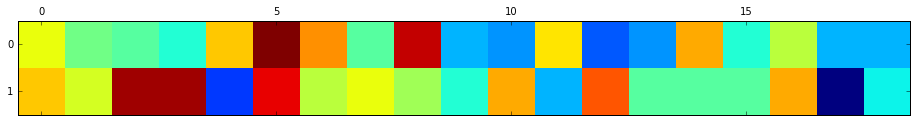

In [21]:
plt.matshow(scores)

In [6]:
def decod_freqs(subject):
    scores = list()
    freqs = np.arange(5., 30., .5)

    for ii, freq in enumerate(freqs):
        decim = 2
        epochs, y = load_data(subject)
        tfr = single_trial_power(epochs._data, sfreq=epochs.info['sfreq'],
                                 frequencies=[freq], 
                                 n_cycles=4)
        epochs.decimate(decim)
        epochs._data = tfr[:, :, 0, ::decim]
        gat = GeneralizationAcrossTime(scorer=scorer_auc, n_jobs=4,
                                       test_times='diagonal',
                                       predict_method='predict_proba')
        gat.fit(epochs, y=y)
        score = gat.score(epochs, y)
        scores.append(score)
    return np.squeeze(scores)

In [ ]:
scores = list()

In [9]:
for subject in subjects[3:]:
    score = decod_freqs(subject)
    scores.append(score)

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


/home/jrking/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   29.9s remaining:   29.9s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.1s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.4s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out 

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   30.1s remaining:   30.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.2s remaining:   10.7s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.8s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.1s remaining:   32.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.0s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.0s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   27.2s remaining:   27.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.5s remaining:   11.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.1s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.6s remaining:   34.6s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.8s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.9s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.4s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.2s remaining:   36.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.3s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   32.3s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.0s remaining:   33.0s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.6s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.1s remaining:   34.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.3s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.5s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   30.3s remaining:  1.5min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.0s remaining:   11.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.4s remaining:   33.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   33.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.9s remaining:   33.9s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.0s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.4s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.1s remaining:   31.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.7s remaining:   11.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.8s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   29.5s remaining:    9.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.1s remaining:   36.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.2s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.8s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.3s remaining:   10.8s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.3s remaining:   34.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    5.1s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   30.7s remaining:   10.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.0s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.3s remaining:   34.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   30.7s remaining:  1.5min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.3s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   31.2s remaining:   10.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.5s remaining:   32.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.9s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.6s remaining:   31.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   32.9s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.4s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   31.2s remaining:   10.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.4s remaining:   33.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.5s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.7s remaining:   11.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.4s remaining:   35.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.5s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   32.6s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.8s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.0s remaining:   36.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.2s remaining:   37.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.4s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.4s remaining:   12.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.3s remaining:   10.8s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.8s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.5s remaining:   34.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.4s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.9s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.5s remaining:   35.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.7s remaining:   32.7s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.2s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.8s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.2s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.5s remaining:   35.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.6s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.7s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.8s remaining:   11.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   31.9s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.5s remaining:   10.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.5s remaining:   35.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.1s remaining:   33.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.6s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.5s remaining:   34.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.8s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.9s remaining:   12.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.1s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.5s remaining:   12.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.9s remaining:   33.9s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.2s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.1s remaining:   32.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.0s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.5s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.0s remaining:   11.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.4s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.7s remaining:   35.7s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.8s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.2s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.7s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.0s remaining:   37.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.3s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.9s remaining:   11.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.0s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.9s remaining:   34.9s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.5s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.0s remaining:   31.0s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.9s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.6s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.3s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.4s remaining:   34.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.5s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.7s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.8s remaining:   33.8s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.9s remaining:   12.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.1s remaining:   32.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.1s remaining:   11.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.9s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   34.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.6s remaining:   31.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   31.7s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.0s remaining:   12.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.3s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.5s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   33.0s remaining:   33.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.9s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.1s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.1s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.8s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.2s remaining:   10.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.4s remaining:   34.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.5s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.5s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.1s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.2s remaining:   35.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.6s remaining:   32.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.7s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.9s remaining:   11.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.3s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.8s remaining:   36.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.9s remaining:   34.9s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.0s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.3s remaining:   11.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.4s remaining:   32.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.9s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.5s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.2s remaining:   32.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.7s remaining:   11.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.3s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.9s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.0s remaining:   34.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.4s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.4s remaining:   11.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.2s remaining:   35.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.4s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.6s remaining:   10.9s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.4s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.8s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.6s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.5s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.0s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.5s remaining:   34.5s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.6s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.0s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.0s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   31.7s remaining:   31.7s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.4s remaining:   12.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.7s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.0s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.8s remaining:   34.8s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.1s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.1s remaining:   37.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.2s remaining:   12.4s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.9s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.8s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.9s remaining:   36.9s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.1s remaining:   12.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.8s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.7s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.2s remaining:   37.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.0s remaining:   10.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.3s remaining:   36.3s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.8s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.1s remaining:   36.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   38.0s remaining:   12.7s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   38.2s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.0s remaining:   36.0s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.3s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.3s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.7s remaining:   34.7s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.9s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.7s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.6s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.7s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.9s remaining:   36.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.5s remaining:   11.8s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.3s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   38.3s remaining:   38.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.1s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.9s remaining:   12.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.2s remaining:   37.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.5s remaining:   32.5s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   32.6s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.2s remaining:   12.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.0s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.9s remaining:   35.9s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.2s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   38.4s remaining:   38.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   38.5s remaining:   12.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.8s remaining:   36.8s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.9s remaining:   12.3s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.9s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.3s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.9s remaining:   12.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.5s remaining:   36.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.1s remaining:   35.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.6s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.5s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.5s remaining:   11.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.8s remaining:   34.8s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.2s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.2s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.7s remaining:   34.7s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.8s remaining:   11.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   33.6s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   34.9s remaining:   34.9s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.4s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   32.7s remaining:  1.6min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   32.8s remaining:   32.8s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.8s remaining:   12.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.2s remaining:   12.1s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.7s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.6s remaining:   36.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   38.0s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   38.1s remaining:   12.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.6s remaining:   35.6s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.7s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.5s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.4s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.9s remaining:   12.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.9s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   33.6s remaining:   11.2s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.5s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.1s remaining:   37.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.1s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   34.0s remaining:   11.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.0s remaining:   36.0s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.3s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.5s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   36.5s remaining:   36.5s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   36.6s remaining:   12.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   36.6s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   34.4s remaining:  1.7min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   35.1s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   35.2s remaining:   35.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   35.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.6s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.1s remaining:   37.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.5s remaining:   12.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.6s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.6s remaining:   37.6s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.7s remaining:   12.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.6s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.2s remaining:    0.7s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.0s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   38.1s remaining:   38.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   38.7s remaining:   12.9s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   38.7s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   35.9s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   37.0s remaining:   12.3s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.8s remaining:   37.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.8s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished


Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   36.6s remaining:  1.8min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   38.1s remaining:   38.1s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   39.3s remaining:   13.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   39.3s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.2s remaining

Computing time-frequency power on single epochs...
No baseline correction applied
The measurement information indicates a low-pass frequency of 64 Hz. The decim=2 parameter will result in a sampling frequency of 64 Hz, which can cause aliasing artifacts.


[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:   32.5s remaining:   10.8s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:   37.1s remaining:  1.9min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:   37.5s remaining:   37.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   37.5s finished
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.4s finished


Computing time-frequency power on single epochs...


[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   1 out of   4 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   3 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.1s finished


KeyboardInterrupt: 

In [ ]:
times = epochs.times
plt.matshow(1-np.mean(scores, axis=0), origin='normal',
            cmap='RdBu_r', vmin=0, vmax=1, aspect='auto',
            extent=[times[0], times[-1], freqs[0], freqs[-1]])
plt.colorbar()